In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 40)

In [3]:
# Collecte des données

data = pd.read_csv("Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv", sep=';',header=[1])

In [4]:
possibles = []

for i in ["Crit'Air 2", "Crit'Air 3", "Crit'Air 4", "Crit'Air 5"] :
    possibles.append(("Diesel", i))
for i in ["Crit'Air 1", "Crit'Air 2", "Crit'Air 3"] :
    possibles.append(("Essence", i))
    
possibles.append(("Hybride rechargeable", "Crit'Air 1"))
possibles.append(('Electrique et hydrogène', "Crit'Air E"))

Dans ce NoteBook, on va utiliser le modèle évoqué dans le sommaire. Celui-ci a pour objectif de modéliser l'évolution du parc automobile jusqu'en 2050 et d'en déduire les émissions de particules fines à l'échelle nationale. Pour ce faire, nous avons calculé dans le NoteBook Pannes.ipynb les probabilités de panne de chaque véhicule en fonction de son âge, et dans Scraping_particules_fines.ipynb nous avons récupéré les moyennes d'émissions de chaque type de véhicules pour les principales particules fines étudiées. 

Commençons par modéliser l'évolution du parc automobile avec les règles évoquées dans le sommaire. Pour rappel, nous nous focalisons sur les véhicules particuliers et les combinaisons carburant-Crit'Air contenues dans le tableau ```possibles```.

In [8]:
# Parc historique

# On se focalise sur les véhicules particuliers
df1 = data.loc[(data["CATEGORIE_VEHICULE"] == "Véhicule particulier")]

def age_num(age) :
    res = []
    for i in range (len(age)) :
        res.append(int(str(age[i])[0:2]))
    return res

# On créé une colonne avec l'âge du véhicule sous forme numérique
df1.insert(loc = 1, column = 'AGE_NUM', value = age_num(np.array(df1['AGE'], dtype = str)))

# On peut se séparer de certaines colonnes
df1 = df1.drop(['CATEGORIE_VEHICULE', 'REGION_CODE', 'REGION_LIBELLE', 'CLASSE_VEHICULE', 'STATUT_UTILISATEUR', 'AGE'], axis = 1)

# On effectue la somme pour les différentes régions et statuts d'utilisateurs
df1 = df1.groupby(['CARBURANT','CRITAIR', 'AGE_NUM'], as_index = False).sum()
df1 = df1.sort_values(by = ['CARBURANT','CRITAIR', 'AGE_NUM'])

In [9]:
# Il faut rajouter les lignes pour les âges de véhicule qui n'existent pas encore

for p in possibles :
    ages = pd.unique(df1.loc[(df1['CARBURANT'] == p[0]) &
                             (df1['CRITAIR'] == p[1])]
                            ['AGE_NUM']
                        )
    for j in range (0, 26) :
        if j not in ages :
            res = [p[0], p[1], j]
            res.extend(np.zeros(12, dtype = int))
            res = pd.DataFrame([res], columns = df1.columns)
            df1 = pd.concat([df1, res], ignore_index = True)

df1 = df1.sort_values(by = ['CARBURANT','CRITAIR', 'AGE_NUM'])
df1 = df1[df1[['CARBURANT', 'CRITAIR']].apply(tuple, axis=1).isin(possibles)]
df1 = df1.reset_index()
df1 = df1.drop(['index'], axis = 1)

df1.head(5)

,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422
1,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355
2,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287
3,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754
4,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306


In [10]:
# On récupère les probabilités de panne déterminées dans le NoteBook Pannes.ipynb

fit_pannes = pd.read_csv('fit_pannes.csv')

def f(carb, crit, age) :
    res = fit_pannes.loc[(fit_pannes['CARBURANT'] == carb) &
                         (fit_pannes['CRITAIR'] == crit)][str(age)]
    return res.sum()

In [11]:
# On définit la fonction qui va, à chaque année, donner le nombre de véhicules tombant en panne

def panne_inter(row) :
    return int(np.random.binomial(row[-1], f(row['CARBURANT'], row['CRITAIR'], row['AGE_NUM'])))

def panne(df : pd.DataFrame) :
    df_cop = df.copy()
    df_cop['Pannes'] = df_cop.apply(panne_inter, axis = 1)
    return df_cop

In [12]:
# Ensuite, on définit la fonction qui nous donne le nombre de véhicules neufs à ajouter sur le parc pour l'année 
# suivante. Celle-ci prend en compte deux choses : le nombre de véhicules tombés en panne (qu'il faut racheter), 
# ainsi que le taux de croissance du parc entier, déterminé dans les statistiques descriptives

def nbr_vhl_neufs_fonc(df : pd.DataFrame, r) :
    col = df.columns.to_list()
    res = 0
    if not (df[col[-1]] == 0).all() :
        res = df[col[-1]].sum() 
    res += r*df[col[-2]].sum()
    return int(res)

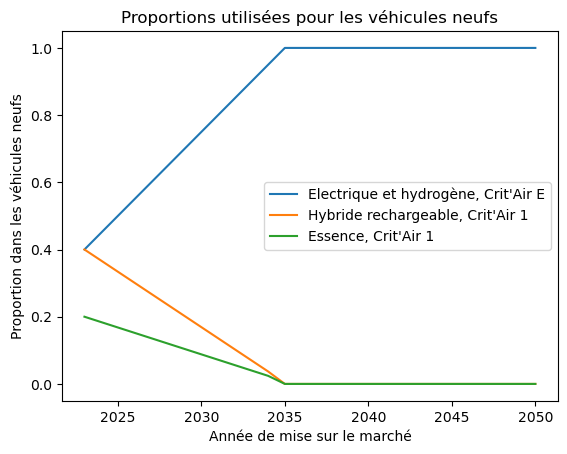

In [15]:
# On définit ici la règle pour l'entrée des véhicules neufs sur le marché, c'est-à-dire quelles proportions de
# chaque type de véhicule est utilisée pour les véhicules neufs en fonction de l'année.

def g(carb, crit, age_num, annee) :
    if age_num != 0 :
        return 0
    if annee < 2035 :
        if crit == "Crit'Air E" and carb == "Electrique et hydrogène" :
            return 0.4 + (annee - 2023)*0.05
        if crit == "Crit'Air 1" and carb == "Hybride rechargeable" :
            return 0.4 - (annee - 2023)*0.033
        if crit == "Crit'Air 1" and carb == "Essence" :
            return 0.2 - (annee - 2023)*0.016
        else : return 0
    else :
        if crit == "Crit'Air E" and carb == "Electrique et hydrogène" :
            return 1
        else : return 0

x = np.arange(2023, 2051, 1)
y = [[],[],[]]

for i in range (len(x)) :
    y[0].append(g("Electrique et hydrogène", "Crit'Air E", 0, x[i]))
    y[1].append(g("Hybride rechargeable", "Crit'Air 1", 0, x[i]))
    y[2].append(g("Essence", "Crit'Air 1", 0, x[i]))

plt.plot(x, y[0], label = "Electrique et hydrogène, Crit'Air E")
plt.plot(x, y[1], label = "Hybride rechargeable, Crit'Air 1")
plt.plot(x, y[2], label = "Essence, Crit'Air 1")

plt.xlabel("Année de mise sur le marché")
plt.ylabel("Proportion dans les véhicules neufs")
plt.title("Proportions utilisées pour les véhicules neufs")
plt.legend(loc="center right")
plt.show()

Nous avons donc fait le choix de ne considérer dans les véhicules neufs mis sur le marché après 2023 que trois types suivants : électrique, hybrique rechargeable et essence Crit'Air 1. Pour interpréter ce graphe, on peut lire : en 2023, 40% des véhicules neufs sont des véhicules électriques, 40% sont des hybrides rechargeables et 20% sont des essences Crit'Air 1. 

Ces choix ont des conséquences fortes sur les résultats de la modélisation. Particulièrement, à partir de 2035 tous les véhicules neufs sont des électriques, ce qui va dans le sens de la législation prévue actuellement. 

In [16]:
# On définit alors la fonction qui va, à chaque année, donner les nombres de véhicules neufs par type

def approx_binomial(n, p) :
    return np.random.normal(n*p, np.sqrt(n*p*(1-p)))

def neufs_inter(row, nbr_vhl_neufs, annee) :
    return (approx_binomial(nbr_vhl_neufs, g(row['CARBURANT'],
                                             row['CRITAIR'], row['AGE_NUM'], annee)))

def vhl_neufs(df : pd.DataFrame, n, a) :
    df_cop = df.copy()
    df_cop['Neufs'] = df_cop.apply(neufs_inter, nbr_vhl_neufs = n, annee = a, axis = 1)
    return df_cop

In [17]:
# Enfin, on définit la fonction qui va, à chaque année, donner la distribution du parc pour l'année suivante
# en fonction des pannes et des véhicules neufs

def final(df_arg : pd.DataFrame, annee) :
    df = df_arg.copy()
    
    # Dans un premier temps, on remet les +25 qui ne sont pas en pannes
    df['25_plus'] = pd.DataFrame(np.transpose(np.zeros(len(df))))
    idx = df.loc[df['AGE_NUM'] == 25].index
    df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]

    # Ensuite, on fait shifter toutes les colonnes qui ne sont pas +25, en sommant sur la colonne créée au-dessus
    df[str(annee)] = pd.DataFrame(np.transpose(np.zeros(len(df))))
    idx_2 = df.loc[df['AGE_NUM'] != 25].index
    idx_3 = df.loc[df['AGE_NUM'] != 0].index
    df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
    df[str(annee)][idx] = df['25_plus'][idx] + df[df.columns.to_list()[-5]].shift(periods = 1, axis = 0)[idx]

    # Ne pas oublier de rajouter les neufs
    df[str(annee)] += df['Neufs']

    return df

In [18]:
# On combine ces fonctions et on les utilise sur les données afin de modéliser l'évolution jusqu'en 2050

df_mod = df1.copy()

for a in range(2023, 2051) :
    df_mod = panne(df_mod)
    df_mod = vhl_neufs(df_mod, nbr_vhl_neufs_fonc(df_mod, 0.05), a)
    df_mod = final(df_mod, a)
    df_mod = df_mod.drop(['Pannes', 'Neufs', '25_plus'], axis = 1)

df_mod.head(5)

/tmp/ipykernel_271/1673964992.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return int(np.random.binomial(row[-1], f(row['CARBURANT'], row['CRITAIR'], row['AGE_NUM'])))
/tmp/ipykernel_271/891830561.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
/tmp/ipykernel_271/891830561.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] +=

,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022,2023,2024,2025,2026,2027,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355,366422.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287,560355.0,366422.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754,819287.0,560355.0,366422.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306,890754.0,819287.0,560355.0,366422.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# On peut visualiser les résultats, en ne prenant plus en compte l'âge des véhicules

df_y = df_mod.drop(['AGE_NUM'], axis = 1)
df_y = df_y.groupby(['CARBURANT', 'CRITAIR'], as_index = False).sum()

df_y.head(10)

,CARBURANT,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022,2023,2024,2025,2026,2027,2028,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Diesel,Crit'Air 2,827265,2377008,3847792,5159016,6373024,7446200,8448397,9334636,10092595,10834684,11296179,11518003,1.148770e+07,1.138266e+07,1.114244e+07,1.072935e+07,1.013296e+07,9.368989e+06,...,6.435414e+06,5.387861e+06,4.367698e+06,3.410647e+06,2.550749e+06,1.822906e+06,1.239130e+06,7.945310e+05,4.793310e+05,2.701430e+05,1.416790e+05,6.841400e+04,3.059900e+04,1.304500e+04,5.583000e+03,2.374000e+03,1.096000e+03,2.410000e+02,3.400000e+01,6.000000e+00
1,Diesel,Crit'Air 3,7742704,7760899,7661174,7578691,7508905,7436490,7308735,7124372,6860385,6607215,6312533,5979327,5.345835e+06,4.606389e+06,3.821252e+06,3.045951e+06,2.330551e+06,1.707235e+06,...,5.159250e+05,3.264630e+05,2.021750e+05,1.241010e+05,7.637100e+04,4.666400e+04,2.297800e+04,1.088700e+04,5.149000e+03,2.452000e+03,1.206000e+03,5.760000e+02,2.850000e+02,1.460000e+02,7.500000e+01,3.700000e+01,1.300000e+01,8.000000e+00,1.000000e+00,0.000000e+00
2,Diesel,Crit'Air 4,5846552,5728183,5612884,5476665,5331907,5141115,4897300,4591724,4166627,3669834,3231905,2862703,2.187777e+06,1.609051e+06,1.137214e+06,7.747740e+05,5.291710e+05,3.527260e+05,...,9.774900e+04,5.360200e+04,2.870300e+04,1.528100e+04,8.105000e+03,4.271000e+03,2.278000e+03,1.228000e+03,6.300000e+02,3.010000e+02,1.590000e+02,9.100000e+01,4.600000e+01,2.000000e+01,1.200000e+01,9.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
3,Diesel,Crit'Air 5,2353317,2257289,2145065,2016424,1880408,1729314,1562729,1390436,1184213,959625,771784,653626,5.684210e+05,4.960820e+05,4.386580e+05,3.900400e+05,3.270560e+05,2.734510e+05,...,1.589190e+05,1.325900e+05,1.104670e+05,9.216400e+04,7.681000e+04,6.414700e+04,5.356200e+04,4.465000e+04,3.723300e+04,3.112900e+04,2.606100e+04,2.173300e+04,1.825500e+04,1.518700e+04,1.269200e+04,1.058900e+04,8.827000e+03,7.465000e+03,6.218000e+03,5.149000e+03
4,Electrique et hydrogène,Crit'Air E,1256,3725,8771,16484,25320,41329,60908,82227,106439,141498,245281,403010,1.935682e+06,3.774367e+06,5.942337e+06,8.454718e+06,1.131868e+07,1.455308e+07,...,2.650366e+07,3.115997e+07,3.606656e+07,4.122405e+07,4.673197e+07,5.240203e+07,5.829313e+07,6.441871e+07,7.074151e+07,7.721571e+07,8.378716e+07,9.041843e+07,9.708881e+07,1.037898e+08,1.105220e+08,1.172766e+08,1.240720e+08,1.309654e+08,1.379876e+08,1.451974e+08
5,Essence,Crit'Air 1,336021,910749,1409943,1960319,2565414,3313130,4213367,5255558,6508307,7853625,8746597,9487099,1.008041e+07,1.058675e+07,1.099950e+07,1.130364e+07,1.147717e+07,1.149343e+07,...,1.038908e+07,9.706134e+06,8.966728e+06,8.170687e+06,7.276310e+06,6.421436e+06,5.607036e+06,4.833025e+06,4.106513e+06,3.425632e+06,2.796793e+06,2.225749e+06,1.715965e+06,1.276803e+06,9.099377e+05,6.299247e+05,4.234287e+05,2.758017e+05,1.736347e+05,1.055817e+05
6,Essence,Crit'Air 2,2952779,2929628,2893449,2856940,2833479,2815089,2782452,2742739,2684999,2639277,2579829,2505199,2.389809e+06,2.246973e+06,2.080574e+06,1.898640e+06,1.707630e+06,1.512162e+06,...,9.653090e+05,8.256780e+05,6.982210e+05,5.828620e+05,4.903260e+05,4.011860e+05,3.159320e+05,2.479250e+05,1.944330e+05,1.527310e+05,1.198120e+05,9.382500e+04,7.386000e+04,5.781500e+04,4.544800e+04,3.556100e+04,2.791900e+04,2.189600e+04,1.718500e+04,1.351700e+04
7,Essence,Crit'Air 3,5400983,5224607,5040386,4850634,4668418,4467292,4235181,3985278,3675165,3327339,2968045,2672601,2.410233e+06,2.165274e+06,1.936279e+06,1.720040e+06,1.518173e+06,1.331485e+06,...,8.788220e+05,7.480880e+05,6.358860e+05,5.407800e+05,4.602260e+05,3.915550e+05,3.330030e+05,2.833830e+05,2.410140e+05,2.050820e+05,1.740500e+05,1.482830e+05,1.260460e+05,1.070110e+05,9.093300e+04,7.722300e+04,6.571400e+04,5.595700e+04,4.765800e+04,4.044800e+04
8,Hybride rechargeable,Crit'Air 1,17579,26333,29545,29834,31325,3632

Nous avons donc obtenu le premier résultat, qui est l'évolution du parc automobile jusqu'en 2050 en fonction des carburants et des Crit'Air. Regardons à quoi ressemblent les courbes.

/tmp/ipykernel_271/691283494.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))


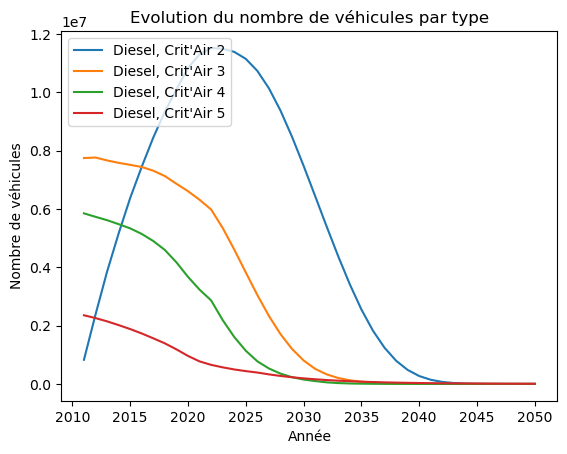

In [20]:
x = np.arange(2011, 2051, 1)

for i in range (0, 4) :
    v = df_y.iloc[i]
    y = np.array(v[2:])
    plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))

plt.xlabel("Année")
plt.ylabel("Nombre de véhicules")
plt.title("Evolution du nombre de véhicules par type")
plt.legend(loc = "upper left")
plt.show()

/tmp/ipykernel_271/3057231457.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))


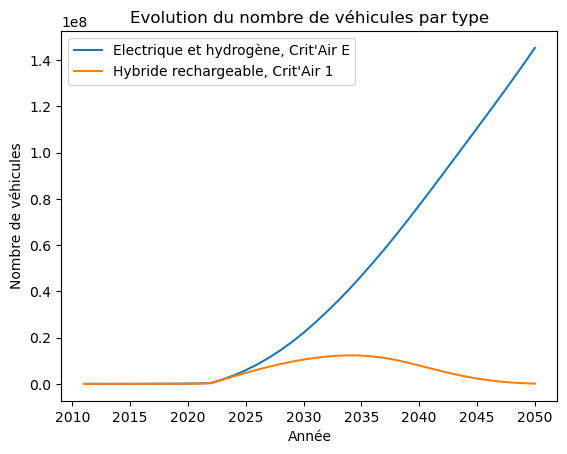

In [21]:
for i in [4, 8] :
    v = df_y.iloc[i]
    y = np.array(v[2:])
    plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))

plt.xlabel("Année")
plt.ylabel("Nombre de véhicules")
plt.title("Evolution du nombre de véhicules par type")
plt.legend(loc = "upper left")
plt.show()

/tmp/ipykernel_271/344821828.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))


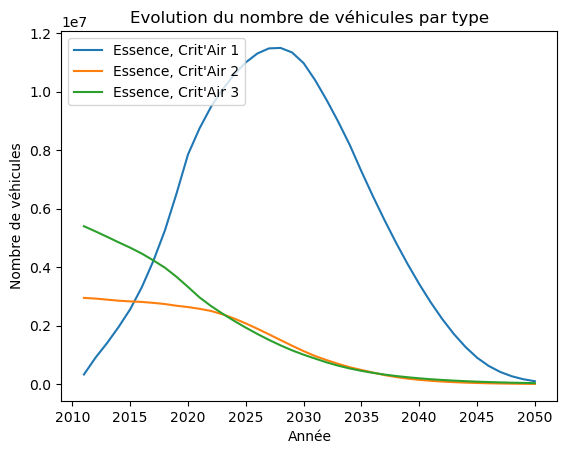

In [22]:
for i in range(5, 8) :
    v = df_y.iloc[i]
    y = np.array(v[2:])
    plt.plot(x, y, label = str(v[0]) + ", " + str(v[1]))

plt.xlabel("Année")
plt.ylabel("Nombre de véhicules")
plt.title("Evolution du nombre de véhicules par type")
plt.legend(loc = "upper left")
plt.show()

Comme l'on s'y attendait du fait des fonctions des proportions choisies pour les véhicules neufs, on arrive en 2050 à uniquement des véhicules électriques sur le marché. Certaines courbes (celles qui étaient encore en ascension en 2022) passent par des pics. 

Maintenant, rajoutons à cela les émissions moyennes de chaque type de véhicules. Il faut pour cela revenir à la norme Euro de chacun, cela dépendant de la date de mise en circulation du véhicule.

In [23]:
# Voici les règles de définition des normes Euro

def norme(age, annee) :
    if annee - age < 1997 : return "Euro 1"
    elif annee - age < 2001 : return "Euro 2"
    elif annee - age < 2006 : return "Euro 3"
    elif annee - age < 2011 : return "Euro 4"
    elif annee - age < 2013 : return "Euro 5a"
    elif annee - age < 2015 : return "Euro 5b"
    elif annee - age < 2018 : return "Euro 6b"
    elif annee - age < 2019 : return "Euro 6c"
    elif annee - age < 2021 : return "Euro 6d-TEMP"
    else : return "Euro 6d"

In [25]:
# On construit alors un DataFrame donnant pour chaque année le nombre de véhicules par combinaison carburant-norme

df_mod2 = df_mod.copy()

# Cette fonction permet d'enlever le str "PARC_" de chaque colonne avant 2023
def enleve_parc(row) :
    s = str(row['Annee'])
    if len(s) > 4 :
        return  int(s[5:])
    return int(s)

# Cette fonction rajoute la colonne avec la norme Euro sur une ligne du DataFrame
def norme_ajout(row) :
    return norme(row["AGE_NUM"], row["Annee"])

df_mod2 = pd.melt(df_mod2, id_vars = ["CARBURANT", "CRITAIR", "AGE_NUM"], var_name = 'Annee')

df_mod2['Annee'] = df_mod2.apply(enleve_parc, axis = 1)
df_mod2['Norme'] = df_mod2.apply(norme_ajout, axis = 1)

df_mod2 = df_mod2.drop(['CRITAIR', 'AGE_NUM'], axis = 1)
df_mod2 = df_mod2.groupby(['CARBURANT', 'Annee', 'Norme'], as_index = False).sum()

df_mod2.head(5)

,CARBURANT,Annee,Norme,value
0,Diesel,2011,Euro 1,690.0
1,Diesel,2011,Euro 2,1650922.0
2,Diesel,2011,Euro 3,5574737.0
3,Diesel,2011,Euro 4,7945416.0
4,Diesel,2011,Euro 5a,1598073.0


In [26]:
# On récupère les tableaux du NoteBook Scraping_particules_fines.ipynb

df_essence = pd.read_csv('emissions_essence.csv')
df_diesel = pd.read_csv('emissions_diesel.csv')

In [27]:
df_diesel.head(10)

,Norme,Euro 1,Euro 2,Euro 3,Euro 4,Euro 5a,Euro 5b,Euro 6b,Euro 6c,Euro 6d -TEMP,Euro 6d
0,Oxydes d'azote (NOx),-,-,500,250,180,180,80,80,80,80
1,Monoxyde de carbone (CO),2 720,1 000,640,500,500,500,500,500,500,500
2,Hydrocarbures (THC),-,-,-,-,-,-,-,-,-,-
3,Hydrocarbures non méthaniques (HCNM),-,-,-,-,-,-,-,-,-,-
4,HC + NOX,970,700,560,300,230,230,170,170,170,170
5,Particules (PM),140,80,50,25,5,45,45,45,45,45
6,Particules (PN) (nb/km),-,-,-,-,6 × 1011,6 × 1011,6 × 1011,6 × 1011,6 × 1011,6 × 1011


In [28]:
df_essence.head(10)

,Norme,Euro 1,Euro 2,Euro 3,Euro 4,Euro 5[25],Euro 6b[26],Euro 6c,Euro 6d -TEMP,Euro 6d
0,Oxydes d'azote (NOx),-,-,150,80,60,60,60,60,60
1,Monoxyde de carbone (CO),2 720,2 200,2 200,1 000,1 000,1 000,1 000,1 000,1 000
2,Hydrocarbures (HC),-,-,200,100,100,100,100,100,100
3,Hydrocarbures non méthaniques (HCNM),-,-,-,-,68,68,68,68,68
4,HC + NOX,970,500,-,-,-,-,-,-,-
5,Particules (PM),-,-,-,-,5[* 1],5[* 1],45,45,45
6,Particules (PN) (nb/km),-,-,-,-,-,6 × 1012[* 2],6 × 1011,6 × 1011,6 × 1011


In [29]:
# On créé un DataFrame depuis ces tableaux, avec pour chaque combinaison carburant-norme les émissions moyennes de 
# particules fines

df_diesel2 = df_diesel.transpose()
norme = df_diesel2.index.to_list()[1:]
df_diesel2 = pd.DataFrame(np.array(df_diesel2.iloc[1:]), columns = df_diesel2.iloc[0])
df_diesel2['Norme'] = pd.DataFrame(norme)
df_diesel2['CARBURANT'] = pd.DataFrame(['Diesel' for i in range (len(df_diesel2))])

df_essence2 = df_essence.transpose()
norme = df_essence2.index.to_list()[1:]
df_essence2 = pd.DataFrame(np.array(df_essence2.iloc[1:]), columns = df_essence2.iloc[0])
df_essence2['Norme'] = pd.DataFrame(norme)
df_essence2['CARBURANT'] = pd.DataFrame(['Essence' for i in range (len(df_essence2))])

df_emissions = pd.concat([df_diesel2, df_essence2], ignore_index=True)
df_emissions = df_emissions.drop(['Particules (PN) (nb/km)', 'Particules (PM)'], axis = 1)

df_emissions.head(5)

Norme,Oxydes d'azote (NOx),Monoxyde de carbone (CO),Hydrocarbures (THC),Hydrocarbures non méthaniques (HCNM),HC + NOX,Norme,CARBURANT,Hydrocarbures (HC)
0,-,2 720,-,-,970,Euro 1,Diesel,NaN
1,-,1 000,-,-,700,Euro 2,Diesel,NaN
2,500,640,-,-,560,Euro 3,Diesel,NaN
3,250,500,-,-,300,Euro 4,Diesel,NaN
4,180,500,-,-,230,Euro 5a,Diesel,NaN


In [31]:
df_mod3 = df_mod2.join(df_emissions.set_index(['Norme', 'CARBURANT']), on = ['Norme', 'CARBURANT'])
col = df_mod3.columns.to_list()[4:]

def calcul_emissions (row) :
    for c in col :
        if row[c] != '-' :
            x = str(row[c]).replace("\xa0", "")
            if x != "nan" :
                row[c] = int(x)*row['value']
    return row

df_mod3 = df_mod3.apply(calcul_emissions, axis = 1)
df_mod3.head(5)

,CARBURANT,Annee,Norme,value,Oxydes d'azote (NOx),Monoxyde de carbone (CO),Hydrocarbures (THC),Hydrocarbures non méthaniques (HCNM),HC + NOX,Hydrocarbures (HC)
0,Diesel,2011,Euro 1,690.0,-,1.876800e+06,-,-,669300.0,NaN
1,Diesel,2011,Euro 2,1650922.0,-,1.650922e+09,-,-,1155645400.0,NaN
2,Diesel,2011,Euro 3,5574737.0,2787368500.0,3.567832e+09,-,-,3121852720.0,NaN
3,Diesel,2011,Euro 4,7945416.0,1986354000.0,3.972708e+09,-,-,2383624800.0,NaN
4,Diesel,2011,Euro 5a,1598073.0,287653140.0,7.990365e+08,-,-,367556790.0,NaN


In [32]:
# Enfin, on joint les tableaux de modélisation et d'émissions, afin d'obtenir pour chaque année l'impact en termes
# de particules fines du parc automobile. Les valeurs d'émissions sont en mg/km.

df_mod4 = df_mod3.drop(['CARBURANT', 'Norme', 'value'], axis = 1)
df_mod4 = df_mod4.replace(to_replace = "-", value = 0)
df_mod4 = df_mod4.replace(to_replace = "nan", value = 0)
df_mod4 = df_mod4.groupby(['Annee'], as_index = False).sum()

df_mod4.head(5)

,Annee,Oxydes d'azote (NOx),Monoxyde de carbone (CO),Hydrocarbures (THC),Hydrocarbures non méthaniques (HCNM),HC + NOX,Hydrocarbures (HC)
0,2011,5.781434e+09,2.447512e+10,0.0,0.0,8.031528e+09,941364000.0
1,2012,5.981728e+09,2.469034e+10,0.0,0.0,8.214322e+09,923271800.0
2,2013,6.138259e+09,2.476282e+10,0.0,0.0,8.334324e+09,903526900.0
3,2014,6.261937e+09,2.471909e+10,0.0,0.0,8.398682e+09,883606400.0
4,2015,6.252401e+09,2.466469e+10,0.0,0.0,8.371468e+09,866374500.0


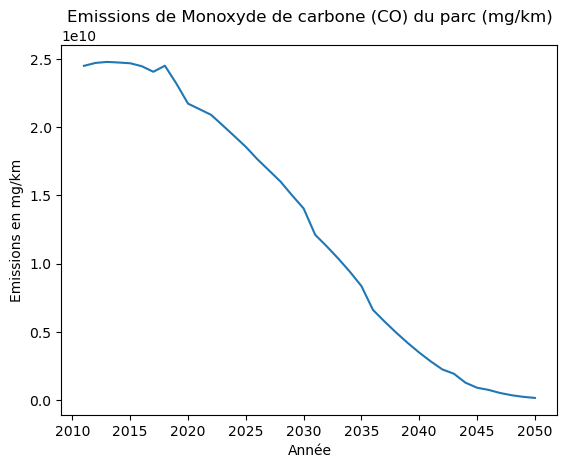

In [34]:
# On peut alors visualiser les résultats

plt.plot(np.array(df_mod4['Annee'], dtype = int), np.array(df_mod4['Monoxyde de carbone (CO)'], dtype = float))

plt.xlabel("Année")
plt.ylabel("Emissions en mg/km")
plt.title("Emissions de Monoxyde de carbone (CO) du parc (mg/km)")
plt.show()

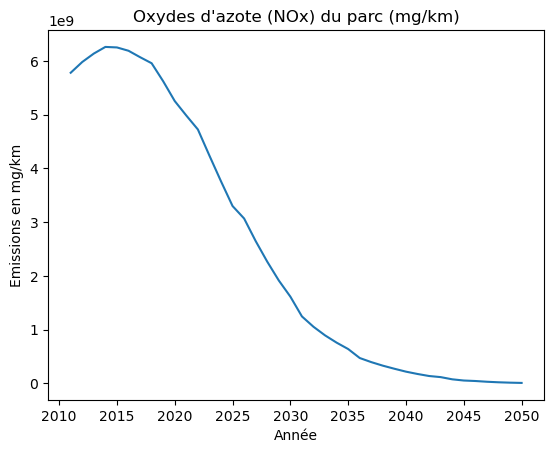

In [35]:
plt.plot(np.array(df_mod4['Annee'], dtype = int), np.array(df_mod4["Oxydes d'azote (NOx)"], dtype = float))

plt.xlabel("Année")
plt.ylabel("Emissions en mg/km")
plt.title("Oxydes d'azote (NOx) du parc (mg/km)")
plt.show()

Nous avons donc obtenu les courbes souhaitées. Ces courbes ne sont pas surprenantes, ayant choisi de diminuer rapidement la part des véhicules non-électriques parmi les véhicules neufs nous nous attendions à une baisse et même un arrêt des émissions de particules fines.